###Connecting to Drive where the dataset is stored:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###Use this snippet to separate the files in the dataset into train and test folders:

In [0]:
#for moving the files into respective test and train directory
#before this use the file_rename.sh shell script to rename all files in
#proper numerical order.

import os
import shutil


cwd=os.path.join(os.getcwd(), 'drive/My Drive')
os.mkdir(os.path.join(cwd,'train'))
os.mkdir(os.path.join(cwd,'test'))
for dir in os.listdir(cwd+'/tomato_disease_dataset'):
	file_list=os.listdir(os.path.join(cwd,'tomato_disease_dataset', dir))
	ln=len(file_list)
	train=file_list[:int(ln*0.8)]
	test=[x for x in file_list if x not in train]
	
	#moving train files:
	os.mkdir(os.path.join(cwd,'train', dir))
	for f in train:
		shutil.move(os.path.join(cwd,'tomato_disease_dataset', dir, f),os.path.join(cwd, 'train', dir, f))
		
	#moving test files:
	os.mkdir(os.path.join(cwd,'test', dir))
	for f in test:
		shutil.move(os.path.join(cwd,'tomato_disease_dataset', dir, f),os.path.join(cwd, 'test', dir, f))
	
	
print("\nDone moving files\n")

###Importing tensorflow and required libraries and also implementing Image Augmentation:

In [4]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

##### CREATING TEST AND TRAIN IMAGE DATA GENERATORS
IMG_SIZE=192

import os
cwd=os.path.join(os.getcwd(), 'drive/My Drive')

image_gen_train = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_gen = image_gen_train.flow_from_directory(batch_size=32, directory = cwd+'/train', shuffle = True, target_size =(IMG_SIZE, IMG_SIZE), class_mode = 'sparse')

image_gen_test = ImageDataGenerator(rescale = 1./255)

test_gen = image_gen_test.flow_from_directory(batch_size=32, directory=cwd+'/test', target_size=(IMG_SIZE, IMG_SIZE), class_mode='sparse')

Found 13324 images belonging to 10 classes.
Found 3337 images belonging to 10 classes.


###Creating the model. Getting pre-trained models using Tensorflow Hub.

In [5]:

'''
imagenet - (192,192) : https://tfhub.dev/google/imagenet/mobilenet_v1_075_192/quantops/feature_vector/3
inception-resnet-v2 - (299, 299) or closer: https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/4
'''

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_075_192/quantops/feature_vector/3", trainable=False, input_shape=(192,192,3)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
  optimizer='adam', 
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 768)               1833084   
_________________________________________________________________
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 2,375,238
Trainable params: 542,154
Non-trainable params: 1,833,084
_________________________________________________________________


###Training the model and also plotting the losses:

Epoch 1/10
417/417 [==============================] - 145s 347ms/step - loss: 0.2376 - acc: 0.9170 - val_loss: 0.2616 - val_acc: 0.9185
Epoch 2/10
417/417 [==============================] - 139s 333ms/step - loss: 0.2303 - acc: 0.9204 - val_loss: 0.2169 - val_acc: 0.9209
Epoch 3/10
417/417 [==============================] - 135s 323ms/step - loss: 0.2277 - acc: 0.9214 - val_loss: 0.3390 - val_acc: 0.9002
Epoch 4/10
417/417 [==============================] - 134s 322ms/step - loss: 0.2172 - acc: 0.9267 - val_loss: 0.2797 - val_acc: 0.9137
Epoch 5/10
417/417 [==============================] - 136s 325ms/step - loss: 0.2152 - acc: 0.9268 - val_loss: 0.3186 - val_acc: 0.9041
Epoch 6/10
417/417 [==============================] - 138s 331ms/step - loss: 0.2046 - acc: 0.9286 - val_loss: 0.2802 - val_acc: 0.9107
Epoch 7/10
417/417 [==============================] - 138s 331ms/step - loss: 0.1977 - acc: 0.9318 - val_loss: 0.2656 - val_acc: 0.9140
Epoch 8/10
417/417 [============================

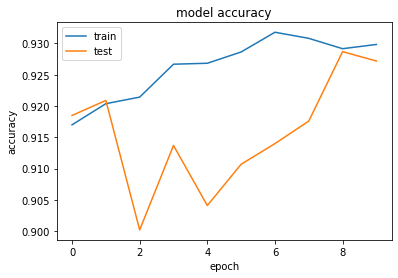

In [9]:
EPOCHS = 10
history = model.fit_generator(train_gen,
                    epochs=EPOCHS,
                    validation_data=test_gen)


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


model.save(cwd+'/my_tomato_model_mobilenet(more_dense).h5')

###Testing the model manually on few random Tomato leaf pictures:

In [11]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np


model=load_model("/content/drive/My Drive/my_tomato_model_mobilenet(more_dense).h5", custom_objects={'KerasLayer':hub.KerasLayer})

dir="/content/drive/My Drive/model_testing/"
img_list=[]
for i in os.listdir(dir):
    img=image.load_img(dir+i, target_size=(192, 192))
    img=image.img_to_array(img)
    img=np.expand_dims(img, axis=0)
    img_list.append(img)

img_list=np.vstack(img_list)

classes = model.predict(img_list, batch_size=10)
for i in classes:
  print(f"Class:{i.argmax()+1}, Accuracy:{i.max()}")





Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Class:5, Accuracy:0.9990901947021484
Class:5, Accuracy:0.9978398084640503
Class:5, Accuracy:0.996399998664856
Class:5, Accuracy:0.9704691171646118
Class:2, Accuracy:0.6752898693084717


# Using VGG16 from keras applications:

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

base_model=VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = Flatten()(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


model.summary()



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 1

In [0]:
#training the model
EPOCHS = 20
history = model.fit_generator(train_gen,
                    steps_per_epoch=416,         
                    epochs=EPOCHS,
                    validation_data=test_gen,
                    validation_steps=104)
model.save(cwd+'/my_tomato_model_vgg16.h5')

Epoch 1/20
416/416 [==============================] - 227s 546ms/step - loss: 0.6980 - acc: 0.8141 - val_loss: 0.6529 - val_acc: 0.8356
Epoch 2/20
416/416 [==============================] - 228s 547ms/step - loss: 0.6726 - acc: 0.8226 - val_loss: 0.5284 - val_acc: 0.8642
Epoch 3/20
416/416 [==============================] - 228s 549ms/step - loss: 0.6647 - acc: 0.8280 - val_loss: 0.6893 - val_acc: 0.8290
Epoch 4/20
416/416 [==============================] - 227s 546ms/step - loss: 0.6677 - acc: 0.8293 - val_loss: 0.9648 - val_acc: 0.8101
Epoch 5/20
416/416 [==============================] - 225s 541ms/step - loss: 0.6573 - acc: 0.8337 - val_loss: 0.5034 - val_acc: 0.8654
Epoch 6/20
416/416 [==============================] - 224s 538ms/step - loss: 0.7225 - acc: 0.8245 - val_loss: 0.5684 - val_acc: 0.8660
Epoch 7/20
416/416 [==============================] - 223s 537ms/step - loss: 0.6460 - acc: 0.8377 - val_loss: 0.7856 - val_acc: 0.8477
Epoch 8/20
416/416 [============================